In [1]:
import project59970 as proj

import numpy as np
import pandas as pd

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
global_temperatures = proj.create_dataframe(dates='dt')    # Global Land Temperatures by Country dataset
us_temperatures = global_temperatures[global_temperatures['Country']=='United States']

In [3]:
us_temperatures.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
554880,1768-09-01,15.420,2.880,United States
554881,1768-10-01,8.162,3.386,United States
554882,1768-11-01,1.591,3.783,United States
554883,1768-12-01,-2.882,4.979,United States
554884,1769-01-01,-3.952,4.856,United States


In [4]:
def get_season(month):
    if month >= 3 and month <= 5:
        return 'Spring'
    elif month >= 6 and month <= 8:
        return 'Summer'
    elif month >= 9 and month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

In [5]:
def get_seasonal_global_temperatures(dataframe, start_year, end_year):

    df = dataframe.copy()

    df['Year'] = df['dt'].apply(lambda x: x.year)
    df['Month'] = df['dt'].apply(lambda x: x.month)
    df['Season'] = df['Month'].apply(get_season)

    years = np.arange(start_year, end_year + 1)

    spring = []
    summer = []
    autumn = []
    winter = []

    for year in years:
        data = df[df['Year'] == year]
        spring.append(data[data['Season']=='Spring']['AverageTemperature'].values.mean())
        summer.append(data[data['Season']=='Summer']['AverageTemperature'].values.mean())
        autumn.append(data[data['Season']=='Autumn']['AverageTemperature'].values.mean())
        winter.append(data[data['Season']=='Winter']['AverageTemperature'].values.mean())
        
    return (spring, summer, autumn, winter)

In [6]:
spring, summer, autumn, winter = get_seasonal_global_temperatures(us_temperatures, 1913, 2013)

In [7]:
years = np.arange(1913, 2014)

/home/brandon/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


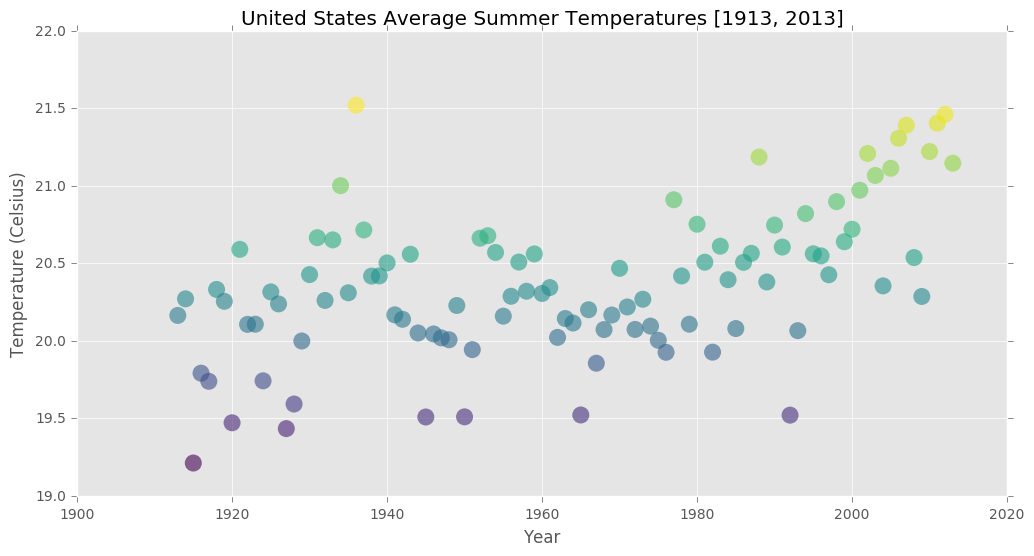

In [8]:
plt.figure(figsize=(12, 6))
# plt.scatter(years, winter, c=winter, s = 150, alpha=0.6, edgecolors='none', cmap='viridis')
plt.scatter(years, summer, c=summer, s = 150, alpha=0.6, edgecolors='none', cmap='viridis')
plt.legend(loc='best')
plt.grid(True)
plt.title("United States Average Summer Temperatures [1913, 2013]")
plt.xlabel("Year")
plt.ylabel("Temperature (Celsius)")
plt.show()

In [9]:
svr_rbf = SVR(kernel='rbf')
svr_lin = SVR(kernel='linear')

In [10]:
future_years = np.arange(1913, 2044)
y_rbf = svr_rbf.fit(years[:, np.newaxis], summer).predict(future_years[:, np.newaxis])

In [11]:
y_lin = svr_lin.fit(years[:, np.newaxis], summer).predict(future_years[:, np.newaxis])

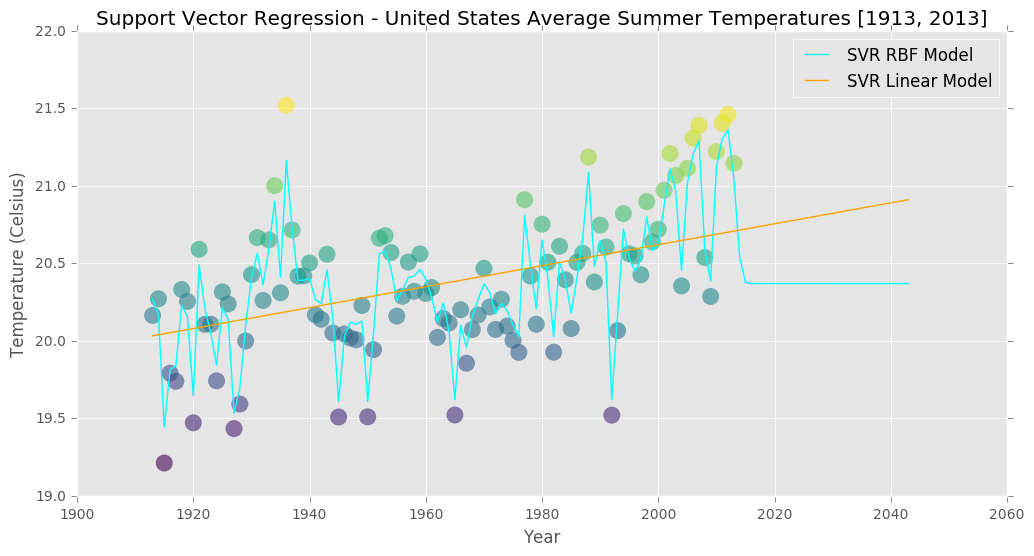

In [12]:
plt.figure(figsize=(12, 6))
plt.scatter(years, summer, c=summer, s = 150, alpha=0.6, edgecolors='none', cmap='viridis')
plt.plot(future_years, y_rbf, c='cyan', label='SVR RBF Model')
plt.plot(future_years, y_lin, c='orange', label='SVR Linear Model')
plt.legend(loc='best')
plt.grid(True)
plt.title("Support Vector Regression - United States Average Summer Temperatures [1913, 2013]")
plt.xlabel("Year")
plt.ylabel("Temperature (Celsius)")
plt.show()

### This is a comparison between a radial basis function SVR and a linear SVR, looking at annual summers only.

### RBF is overfitted and is not adequate in making predictions

In [13]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

In [14]:
svr.fit(years[:, np.newaxis], summer)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'gamma': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02]), 'C': [1.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [15]:
kr.fit(years[:, np.newaxis], summer)

GridSearchCV(cv=5, error_score='raise',
       estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=0.1, kernel='rbf',
      kernel_params=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'gamma': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02]), 'alpha': [1.0, 0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [16]:
sv_ratio = svr.best_estimator_.support_.shape[0] / len(years)
print("Support vector ratio: %.3f" % sv_ratio)

Support vector ratio: 0.792


In [24]:
summer_svr = svr.predict(years[:, np.newaxis])

In [25]:
summer_kr = kr.predict(years[:, np.newaxis])

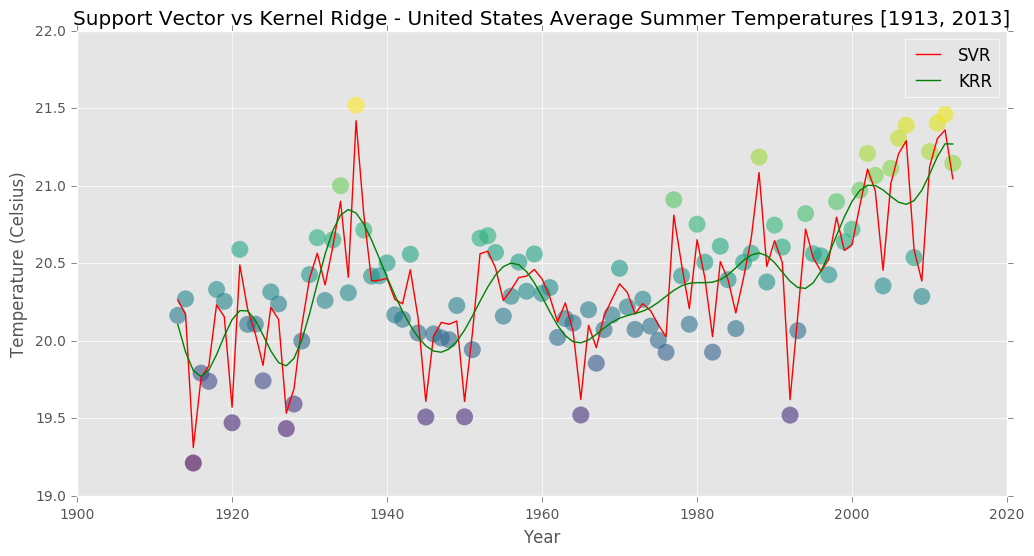

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(years, summer_svr, c='r', label='SVR')
plt.plot(years, summer_kr, c='g', label='KRR')
plt.scatter(years, summer, c=summer, s = 150, alpha=0.6, edgecolors='none', cmap='viridis')

plt.legend(loc='best')
plt.grid(True)
plt.title("Support Vector vs Kernel Ridge - United States Average Summer Temperatures [1913, 2013]")
plt.xlabel("Year")
plt.ylabel("Temperature (Celsius)")
plt.show()

### Here we are still looking at annual summers but we are comparing radial basis function SVR to kernel ridge regression.